**2. Etapa de preprocesado de texto**
---
Importamos las librerías necesarias y cargamos el dataset

In [ ]:
!pip install pandas
!pip install nltk
!pip install regex
!pip install num2words

In [ ]:
import json
import pandas as pd

file_name = 'Pet_Supplies_5_reducido.json'

# Leemos el archivo
with open(file_name, 'r') as f:
    file_content = f.read()

try:
    data = json.loads(file_content)
    df = pd.DataFrame(data)
    print(df.head())

except json.JSONDecodeError as e:
    print(f"JSONDecodeError: {e.msg}, at line {e.lineno} column {e.colno}")


   overall  verified   reviewTime      reviewerID        asin  \
0      5.0      True  05 27, 2014   AVA8KXONIGNV4  B000FPH1CA   
1      5.0      True  02 16, 2014   A60D5HQFOTSOM  B005GSEC3W   
2      5.0      True  09 22, 2014  A1BBTVAGN6YIGD  B000WFKTWM   
3      1.0     False  08 18, 2017   AS3JM3ZLNJ5DR  B010MVG6ZY   
4      2.0      True  09 25, 2016  A38S15PFJIWRYU  B00JZIDCC6   

                                               style     reviewerName  \
0  {'Flavor Name:': ' Song Plus', 'Pattern:': ' C...  Victoria Puffer   
1  {'Size:': ' 18" L X 13" W X 13" H', 'Color:': ...   DanCooperMedia   
2                           {'Size:': ' 16 lb. Bag'}    ShootingStarz   
3  {'Size:': ' 100-Count Wipes', 'Color:': ' Unsc...        B. Graham   
4  {'Size:': ' 9-Count', 'Flavor Name:': ' Chicke...  Amazon Customer   

                                          reviewText  \
0  This product and actualy be eatten by a human....   
1  I have a Persian cat. He likes sleeping in thi...   
2 

Comenzamos con el procesamiento

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from num2words import num2words
from nltk.stem import WordNetLemmatizer

# Descargar recursos de NLTK necesarios
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Cargar las stopwords en inglés
stop_words = set(stopwords.words('english'))

# Inicializar lematizador
lemmatizer = WordNetLemmatizer()

# Función para eliminar signos de puntuación
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation))

# Función para eliminar stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Función para convertir números a texto
def convert_numbers_to_text(text):
    words = text.split()
    text_with_numbers = [num2words(word) if word.isdigit() else word for word in words]
    return ' '.join(text_with_numbers)

# Función para lematizar texto
def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)


# Función principal de preprocesamiento
def preprocess_review(review):
    # Convertir a minúsculas
    review = review.lower()
    # Convertir números a texto
    review = convert_numbers_to_text(review)
    # Eliminar signos de puntuación
    review = remove_punctuation(review)
    # Eliminar stopwords
    review = remove_stopwords(review)
    # Lematizar texto
    review = lemmatize_text(review)
    # Eliminar caracteres no alfabéticos y extra espacios
    review = re.sub(r'\s+', ' ', review).strip()
    return review


# Aplicar la función de preprocesamiento a una muestra del dataset
sample_reviews = df['reviewText'].dropna().sample(n=5, random_state=1).tolist()
processed_reviews = [preprocess_review(review) for review in sample_reviews]


# Mostrar las reviews originales y procesadas
for i in range(len(sample_reviews)):
    print(f"Original: {sample_reviews[i]}")
    print(f"Procesada: {processed_reviews[i]}")
    print()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Original: We were given a Blue one as a gift and all the cats went crazy for it. but one of our cats loved it so much he would carry it around so it was always int he room he was planning on staying in. after a year the wand broke but he still loved it. i searched and searched for another one but couldn't find one anywhere. Eventually I spent an hour looking on Amazon for this toy, the white quill-like feathers don't show up very well in the picture. I bought three. I put them in his stocking for Christmas and the little mastermind managed to pull all three out and bring them into the bedroom while we were sleeping. He now carries all three of them around. Of course when we are actually playing with him, he goes crazy. His face is terrifying when he's playing, it's really awesome. So many toys I buy for the little monsters are not as popular as the box they came in but this toy was way better then the box.
Procesada: given blue one gift cat went crazy one cat loved much would carry aro

Se lo aplicamos ahora a todo el dataset.

In [ ]:
# Aplicar la función de preprocesamiento a todo el dataset
df['processed_reviewText'] = df['reviewText'].dropna().apply(preprocess_review)

# Mostrar las primeras filas del DataFrame procesado
df[['reviewText', 'processed_reviewText']].head()


,reviewText,processed_reviewText
0,This product and actualy be eatten by a human....,product actualy eatten human one would give in...
1,I have a Persian cat. He likes sleeping in thi...,persian cat like sleeping provided pillow soft...
2,"I have a (slightly older than) 2 year old, 13 ...",slightly older two year old thirteen pound mal...
3,I was bringing home a new puppy to live with m...,bringing home new puppy live two cat used clot...
4,These bones were suggest to buy with a blue ch...,bone suggest buy blue chewable bone insert wou...


Guardamos el dataset para usarlo en el ejercicio 3

In [ ]:
df.to_csv('processed_pet_supplies_reviews.csv', index=False)


Una vez procesado el texto podemos comparar su estado anterior en el ejercicio 1 con esta una vez se ha procesado el texto

Número de tokens que componen el vocabulario: 1226731


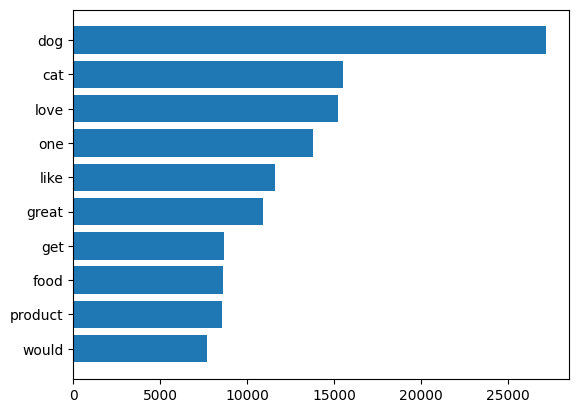

In [ ]:
import re
import matplotlib.pyplot as plt
from collections import Counter

# Unir todas las reseñas en un solo texto
all_reviews = ' '.join(df['processed_reviewText'].dropna().astype(str))

# Tokenizar las palabras
words_nltk = re.findall(r'\w+', all_reviews.lower())

# Número de tokens que componen el vocabulario
vocab_size = len(words_nltk)
print(f"Número de tokens que componen el vocabulario: {vocab_size}")

wf = Counter(words_nltk)
wf_most_common = wf.most_common(10)
wf_most_common

words = [w[0] for w in wf_most_common]
freqs = [w[1] for w in wf_most_common]
freqs, words = zip(*sorted(zip(freqs, words)))
plt.barh(words, freqs)
plt.title('Top 10 tokens más frecuentes')
plt.show()

Vemos que efectivamente hemos reducido el número total de tokens que componen nuestro vocabulario y que además ahora se repiten más palabras que no son stop words y por lo tanto nos aportan mayor información. Veámos también los bigramas y trigramas más comunes

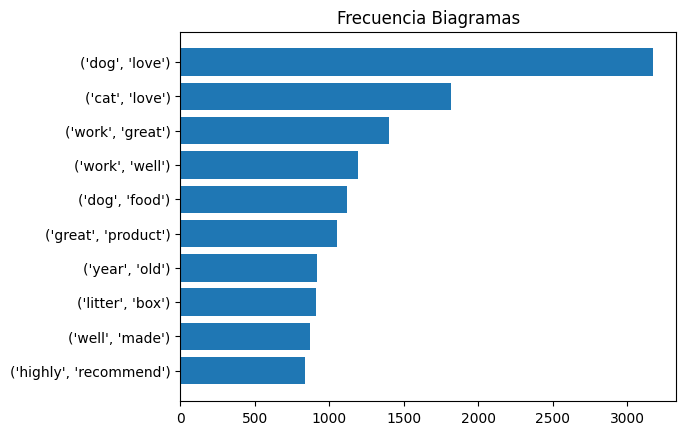

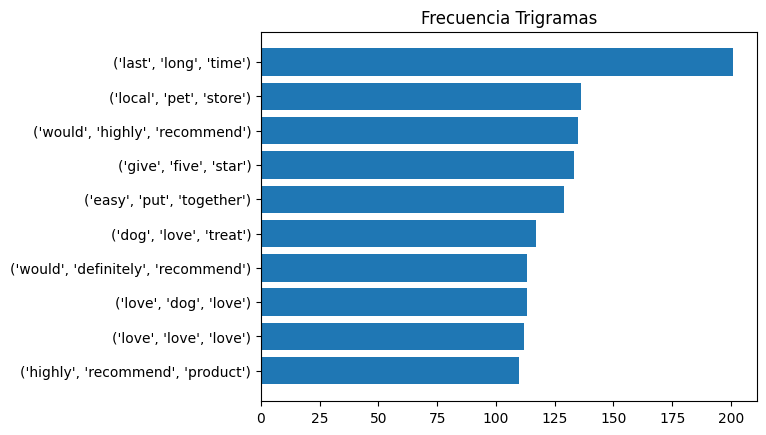

In [ ]:
from nltk import ngrams
from nltk.probability import FreqDist

# Cálculo Bigramas
bigrams_ = list(ngrams(words_nltk, 2))
trigrams_ = list(ngrams(words_nltk, 3))
bg_freq = FreqDist(bigrams_)
tg_freq = FreqDist(trigrams_)
bg_freq.most_common(10)
tg_freq.most_common(10)
bg_freq_most_common = bg_freq.most_common(10)
bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]

# Cálculo Trigramas
tg_freq_most_common = tg_freq.most_common(10)
tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]
bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

# Mostramos
plt.barh(bgs_, bgs_f_)
plt.title('Frecuencia Biagramas')
plt.show()

plt.barh(tgs_, tgs_f_)
plt.title('Frecuencia Trigramas')
plt.show()


Observamos una mayor riqueza en las relaciones de las palabras que tenemos en comparación a lo que teníamos en el texto sin procesar